In [1]:
!pip install kagglehub[pandas-datasets]


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

class ModelCompare:

    def __init__(self, model_instances: list = []):
        self.models = model_instances
        self.pca = None

    def fit(self, X, y, *args, **kwargs):
        for model in self.models:
            model.fit(X, y, *args, **kwargs)

    def predict(self, data, *args, **kwargs):
        return [model.predict(data, *args, **kwargs) for model in self.models]

    def plot(self, X, y, labels: list[tuple[str, str]] = [], titles: list[str] = [],
         offset: float = 0.5, step: float = 0.01, use_pca: bool = True,
         max_points_per_axis: int = 400):
    
        # --- Prepare data (with optional PCA)
        if X.shape[1] > 2 and use_pca:
            self.pca = PCA(n_components=2)
            data = self.pca.fit_transform(X)
        elif X.shape[1] >= 2:
            data = X[:, :2]
        else:
            raise ValueError("Need at least 2 features for 2D plotting.")
    
        # --- Define plotting grid
        x_min, x_max = data[:, 0].min() - offset, data[:, 0].max() + offset
        y_min, y_max = data[:, 1].min() - offset, data[:, 1].max() + offset
    
        nx = min(max_points_per_axis, int((x_max - x_min) / step))
        ny = min(max_points_per_axis, int((y_max - y_min) / step))
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, nx),
            np.linspace(y_min, y_max, ny)
        )
    
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        if use_pca and self.pca is not None:
            grid_points = self.pca.inverse_transform(grid_points)
    
        # --- Predict continuous outputs
        predictions = self.predict(grid_points)
        for i, p in enumerate(predictions):
            predictions[i] = p.reshape(xx.shape)
    
        # --- Create subplots
        nrows = (len(self.models) + 1) // 2
        fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(10, 5 * nrows))
        ax = ax.flatten()
    
        # --- Use a continuous color map
        cmap = plt.cm.viridis
    
        for i, p in enumerate(predictions):
            contour = ax[i].contourf(xx, yy, p, cmap=cmap, alpha=0.8)
            scatter = ax[i].scatter(data[:, 0], data[:, 1], c=y, edgecolor='k', cmap=cmap)
            fig.colorbar(contour, ax=ax[i], label='Predicted value')
    
            # Labeling
            if i < len(labels) and labels[i]:
                if len(labels[i]) > 0:
                    ax[i].set_xlabel(labels[i][0])
                if len(labels[i]) > 1:
                    ax[i].set_ylabel(labels[i][1])
            if i < len(titles) and titles[i]:
                ax[i].set_title(titles[i])
            else:
                ax[i].set_title(f"Model {i+1}")
    
        for j in range(i + 1, len(ax)):
            fig.delaxes(ax[j])
    
        plt.tight_layout()
        plt.show()



# Carregando o dataset

Esse dataset será usado para regressão dos preços de carros. Os capos presentes estão a seguir. O dataset veio do seguinte link: [Car Price Prediction](https://www.kaggle.com/datasets/aliiihussain/car-price-prediction)

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "car_price_prediction_.csv"

df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "aliiihussain/car-price-prediction",
  file_path,
)

df.head(5)

,Car ID,Brand,Year,Engine Size,Fuel Type,Transmission,Mileage,Condition,Price,Model
0,1,Tesla,2016,2.3,Petrol,Manual,114832,New,26613.92,Model X
1,2,BMW,2018,4.4,Electric,Manual,143190,Used,14679.61,5 Series
2,3,Audi,2013,4.5,Electric,Manual,181601,New,44402.61,A4
3,4,Tesla,2011,4.1,Diesel,Automatic,68682,New,86374.33,Model Y
4,5,Ford,2009,2.6,Diesel,Manual,223009,Like New,73577.10,Mustang


# Formatar o dataset

Pegamos informações sobre a prsença de nulos / tipos de cada coluna

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Car ID        2500 non-null   int64  
 1   Brand         2500 non-null   object 
 2   Year          2500 non-null   int64  
 3   Engine Size   2500 non-null   float64
 4   Fuel Type     2500 non-null   object 
 5   Transmission  2500 non-null   object 
 6   Mileage       2500 non-null   int64  
 7   Condition     2500 non-null   object 
 8   Price         2500 non-null   float64
 9   Model         2500 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 195.4+ KB


Aqui nós removemos todas as colunas que não são relevantes para a predição. Mais especificamente, removemos Car ID. 

In [3]:
df = df.iloc[:, 1:]

Transformar colunas categoricas em númericas

In [4]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = ["Brand", "Fuel Type", "Transmission", "Condition", "Model"]
encoder = LabelEncoder()

for col in categorical_columns:
    df[col] = encoder.fit_transform(df[col])

Verificar que as colunas certas foram transformadas

In [7]:
df.describe()

,Brand,Year,Engine Size,Fuel Type,Transmission,Mileage,Condition,Price,Model
count,2500.000000,2500.0000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,3.001600,2011.6268,3.465240,1.482400,0.523200,149749.844800,1.007600,52638.022532,13.255600
std,2.020503,6.9917,1.432053,1.130576,0.499561,87919.952034,0.822565,27295.833455,8.106229
min,0.000000,2000.0000,1.000000,0.000000,0.000000,15.000000,0.000000,5011.270000,0.000000
25%,1.000000,2005.0000,2.200000,0.000000,0.000000,71831.500000,0.000000,28908.485000,6.000000
50%,3.000000,2012.0000,3.400000,1.000000,1.000000,149085.000000,1.000000,53485.240000,13.000000
75%,5.000000,2018.0000,4.700000,3.000000,1.000000,225990.500000,2.000000,75838.532500,20.000000
max,6.000000,2023.0000,6.000000,3.000000,1.000000,299967.000000,2.000000,99982.590000,27.000000


Separa o dataset em X e y

In [5]:
import numpy as np

X, y = np.c_[df.iloc[:, 0:7], df.iloc[:, -1]], df.iloc[:, 7].values

Padroniza os valores de X e y

In [59]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
X_t = scaler.fit_transform(X, y)

Separa o dataset em treinamento e teste

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_t, y, random_state=69)

# Treinar os modelos

Treinando a regressão linear e random forest

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

linear_m = LinearRegression()
forest = RandomForestRegressor()

In [62]:
linear_m.fit(X_train, y_train)
forest.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [55]:
compare = ModelCompare([linear_m, forest])

Os plots são os pontos representados com apenas 2 componentes para obter uma visualização em 2 dimensões dos resultados obtidos pelo modelo. A esquerda o modelo linear e a direita o random forest

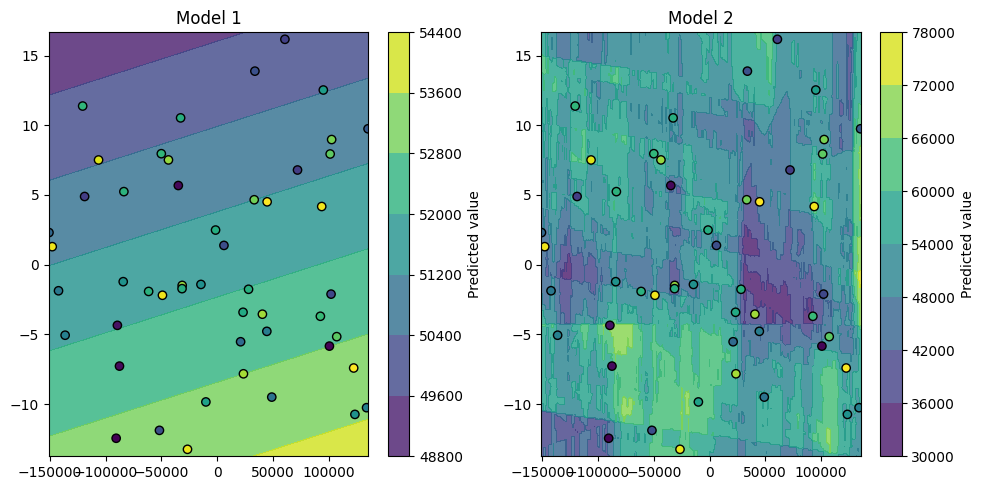

In [41]:
compare.plot(X_train[:50], y_train[:50], step=0.1)

Resultado do modelo linear:

In [16]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

Resultado da Regressão Linear:

In [63]:
preds = linear_m.predict(X_test)

print('Score:', linear_m.score(X_test, y_test))
print('R2:', r2_score(y_test, preds))
print('MAE:', mean_absolute_error(y_test, preds))
print('MSE:', mean_squared_error(y_test, preds))

Score: -0.01602284221505501
R2: -0.01602284221505501
MAE: 23614.016409482057
MSE: 739320824.277077


Resultado do random forest:

In [65]:
preds = forest.predict(X_test)

print('Score:', forest.score(X_test, y_test))
print('R2:', r2_score(y_test, preds))
print('MAE:', mean_absolute_error(y_test, preds))
print('MSE:', mean_squared_error(y_test, preds))

Score: -0.04461248882698721
R2: -0.04461248882698721
MAE: 23825.31900144
MSE: 760124412.7602285


O resultado obtido foi muito ruim, dado que ambos os scores estão abaixo de 0.0 que seria o esperado caso o modelo errasse todos os pontos.